In [4]:
%matplotlib inline
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence


In [5]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.attention = SelfAttention(inp)  # Attention layer with input dimension
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp = inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Applying attention first
        attn_out = self.attention(x)
        # Feeding the output of the attention layer into the RNN
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Applying the final output layer
        out = torch.sigmoid(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Feeding the output of the attention layer into the RNN
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


model = NetRNNWithAttention()

In [7]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.resetHidden()
        self.inp = inp

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                out, h0 = self.rnnLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                H.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
        return numpy.array(O), numpy.array(H)


model = NetRNN()

In [8]:
import numpy as np


def generateTrainData(num_samples, min_length, max_length):
    s = []  # Sequences (list of arrays)
    t = []  # Targets (list of labels)

    for _ in range(num_samples):
        # Randomized common length between min_length and max_length
        common_length = np.random.randint(min_length, max_length + 1)

        # Initialize arrays with zeros instead of 0.5
        array_A = np.zeros(common_length)
        array_B = np.zeros(common_length)
        array_C = np.zeros(common_length)

        # Random index for array A
        index_A = np.random.randint(common_length)
        value_A = np.random.choice([-1, 1])  # Change here: Use -1 and 1
        array_A[index_A] = value_A

        # Different random index for array B
        indices_B = np.delete(np.arange(common_length), index_A)
        index_B = np.random.choice(indices_B)
        value_B = np.random.choice([-1, 1])  # Change here: Use -1 and 1
        array_B[index_B] = value_B

        # Setting the last index of array C to either -1 or 1
        value_C = np.random.choice([-1, 1])  # Change here: Use -1 and 1
        array_C[-1] = value_C

        # Generating label based on value_C
        # Here, map -1 to 0 and 1 to 1 for the logic
        mapped_value_A = 1 if value_A == 1 else 0
        mapped_value_B = 1 if value_B == 1 else 0
        label = int(
            (mapped_value_A != mapped_value_B)
            if value_C == -1
            else (mapped_value_A == mapped_value_B)
        )
        label_arr = [label]

        # Combine arrays
        combined_array = np.vstack([array_A, array_B, array_C]).T

        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)  # Returning as lists

In [9]:
num_seq = 2
array_min_length = 5
array_max_length = 10
sequences, labels = generateTrainData(num_seq, array_min_length, array_max_length)
sequences, labels

([array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 1.,  0.,  0.],
         [ 0.,  0., -1.]]),
  array([[ 0.,  0.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  1., -1.]])],
 array([[0],
        [1]]))

In [10]:
model = NetRNNWithAttention()
sequences, labels = generateTrainData(100, 10, 10)
output = model(torch.Tensor(sequences))
print(output.shape)
print(model)

torch.Size([100])
NetRNNWithAttention(
  (attention): SelfAttention(
    (query): Linear(in_features=3, out_features=3, bias=True)
    (key): Linear(in_features=3, out_features=3, bias=True)
    (value): Linear(in_features=3, out_features=3, bias=True)
    (softmax): Softmax(dim=2)
  )
  (rnnLayer): RNN(3, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=1, bias=True)
)


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_71898/902665227.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  output = model(torch.Tensor(sequences))


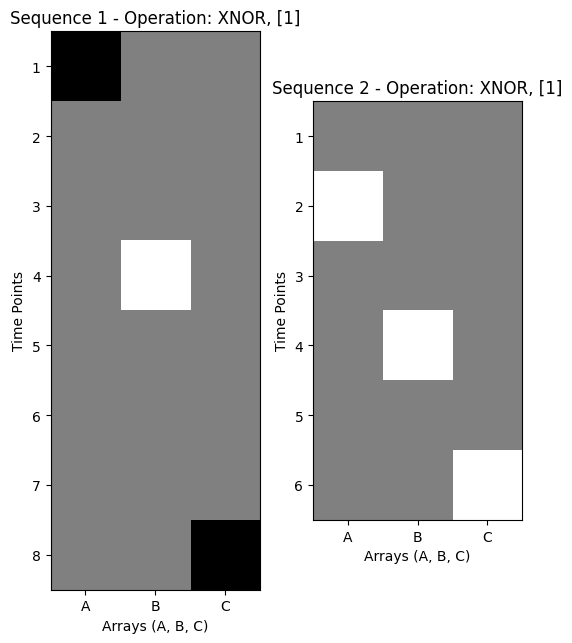

In [18]:
# Assuming sequences and labels are already generated using generateTrainData
num_samples = len(sequences)  # Number of samples to display

# Plotting
# Adjust the figure size to accommodate horizontal layout
plt.figure(figsize=(3 * num_samples, 15))

for i, (seq, label) in enumerate(zip(sequences, labels)):
    # Reshape each sequence for visualization
    reshaped_sequence = seq  # Use the sequence as it is

    # Add a subplot for each sequence in a horizontal layout
    ax = plt.subplot(1, num_samples, i + 1)
    img = ax.imshow(reshaped_sequence, cmap="gray", vmin=0.0, vmax=1.0)

    # Determine the operation title based on the label
    operation_title = "XOR" if label == 0 else "XNOR"

    # Setting the title with the operation label
    ax.set_title(f"Sequence {i+1} - Operation: {operation_title}, {label}")

    # Setting labels for features (X-axis) and detailed time points (Y-axis)
    ax.set_xlabel("Arrays (A, B, C)")
    ax.set_ylabel("Time Points")

    # Setting tick marks for each array on the X-axis
    ax.set_xticks(range(3))
    ax.set_xticklabels(["A", "B", "C"])

    # Setting tick marks for each time point on the Y-axis
    # Here, the number of ticks should be equal to the length of the sequence (number of rows)
    ax.set_yticks(range(reshaped_sequence.shape[0]))
    ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

# Adding a colorbar as the key, placed at the side
# cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust these values as needed for positioning
# cbar = plt.colorbar(img, cax=cbar_ax)
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['0 (Black)', '1 (White)'])

# Adjust the main figure to make room for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [14]:
collectorA = dict()
array_min_length = 20  # Define the min length of Arrays A, B, C
array_max_length = 20  # Define the max length of Arrays A, B, C
num_samples = 100
for rep in range(1):
    for kind in ["NetRNNWithAttention", "RNN"]:
        if kind == "RNN":
            model = NetRNN(hidden_dim=12, inp=3)
        if kind == "NetRNNWithAttention":
            model = NetRNNWithAttention(hidden_dim=12, inp=3)
        optimizer = optim.Adam(model.parameters())
        error = nn.MSELoss()
        acc = 0.0
        W = []
        A = []

        while acc < 0.97:
            model.resetHidden()
            sequences, targets = generateTrainData(
                num_samples, array_min_length, array_max_length
            )
            sequences = numpy.array(sequences)  # Convert to numpy array

            divs = []
            for seq, target in zip(sequences, targets):
                optimizer.zero_grad()
                # Process each sequence individually
                seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(
                    0
                )  # Add batch dimension
                target_tensor = torch.tensor(
                    target, dtype=torch.float32
                )  # Add batch dimension
                # seq_tensor =torch.Tensor(seq.reshape(1, seq.shape[0], 3))
                output = model(seq_tensor)
                loss = error(output, target_tensor)
                loss.backward()
                optimizer.step()

                div = output.detach().numpy() - target_tensor.numpy()
                divs.append(1.0 - abs(div).mean())

            W.append(loss.item())
            acc = mean(divs)
            A.append(acc)
            print(f"{kind}, rep: {rep}, epoch: {len(A) }, acc: {acc}")

            # Restart training if not converging
            # if acc < 0.97 and len(A) > 2000:
            #     if kind == "RNN":
            #         model = NetRNN(hidden_dim=12, inp=3)
            #     if kind == "NetRNNWithAttention":
            #         model = NetRNNWithAttention(hidden_dim=12, inp=3)
            #     optimizer = optim.Adam(model.parameters())
            #     acc = 0.0
            #     W = []
            #     A = []
            #     print("repeat")

        # torch.save(model, f"model{rep}.pth")
        collectorA["{0} {1}".format(kind, rep)] = A
        torch.save(model, "models/model_{0}_{1}.model".format(kind, rep))
        print("{0} {1}".format(kind, rep), len(A))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NetRNNWithAttention, rep: 0, epoch: 1, acc: 0.49657647252082826
NetRNNWithAttention, rep: 0, epoch: 2, acc: 0.49890333771705625
NetRNNWithAttention, rep: 0, epoch: 3, acc: 0.4995148006081581
NetRNNWithAttention, rep: 0, epoch: 4, acc: 0.5039817461371422
NetRNNWithAttention, rep: 0, epoch: 5, acc: 0.5138757389783859
NetRNNWithAttention, rep: 0, epoch: 6, acc: 0.4967470771074295
NetRNNWithAttention, rep: 0, epoch: 7, acc: 0.50701914280653
NetRNNWithAttention, rep: 0, epoch: 8, acc: 0.49506733924150464
NetRNNWithAttention, rep: 0, epoch: 9, acc: 0.5018748074769974
NetRNNWithAttention, rep: 0, epoch: 10, acc: 0.49896101772785184
NetRNNWithAttention, rep: 0, epoch: 11, acc: 0.5008358627557754
NetRNNWithAttention, rep: 0, epoch: 12, acc: 0.4987711468338966
NetRNNWithAttention, rep: 0, epoch: 13, acc: 0.4983831408619881
NetRNNWithAttention, rep: 0, epoch: 14, acc: 0.4974798372387886
NetRNNWithAttention, rep: 0, epoch: 15, acc: 0.49953308820724485
NetRNNWithAttention, rep: 0, epoch: 16, acc: 0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNN, rep: 0, epoch: 2, acc: 0.5027287989854813
RNN, rep: 0, epoch: 3, acc: 0.5029849541187287
RNN, rep: 0, epoch: 4, acc: 0.5060614404082299
RNN, rep: 0, epoch: 5, acc: 0.49874862402677533
RNN, rep: 0, epoch: 6, acc: 0.5023061186075211
RNN, rep: 0, epoch: 7, acc: 0.5117669582366944
RNN, rep: 0, epoch: 8, acc: 0.5052479359507561
RNN, rep: 0, epoch: 9, acc: 0.5002222239971161
RNN, rep: 0, epoch: 10, acc: 0.505047683417797
RNN, rep: 0, epoch: 11, acc: 0.5077277740836144
RNN, rep: 0, epoch: 12, acc: 0.49763812869787216
RNN, rep: 0, epoch: 13, acc: 0.5021501323580742
RNN, rep: 0, epoch: 14, acc: 0.5036616080999374
RNN, rep: 0, epoch: 15, acc: 0.5003461024165153
RNN, rep: 0, epoch: 16, acc: 0.500515504181385
RNN, rep: 0, epoch: 17, acc: 0.499927191734314
RNN, rep: 0, epoch: 18, acc: 0.5015209537744522
RNN, rep: 0, epoch: 19, acc: 0.5030335518717766
RNN, rep: 0, epoch: 20, acc: 0.5127312737703323
RNN, rep: 0, epoch: 21, acc: 0.5149315011501312
RNN, rep: 0, epoch: 22, acc: 0.5061940616369247
R

In [ ]:
array_min_length = 5
array_max_length = 10
analysis_interval = 500  # Interval for performing analysis

# Training Loop
for rep in range(1):
    model = NetRNNWithAttention(hidden_dim=12)
    optimizer = optim.Adam(model.parameters())
    error = nn.MSELoss()
    acc = 0.0
    W = []  # To store loss values
    A = []  # To store accuracy values

    iteration = 0
    while acc < 0.97:
        model.resetHidden()
        sequences, targets = generateTrainData(2, array_min_length, array_max_length)

        divs = []
        for seq, target in zip(sequences, targets):
            optimizer.zero_grad()
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
            target_tensor = torch.tensor([target], dtype=torch.float32)

            output = model(seq_tensor)
            loss = error(output, target_tensor)
            loss.backward()
            optimizer.step()

            div = output.detach().numpy() - target_tensor.numpy()
            divs.append(1.0 - abs(div).mean())

        W.append(loss.item())
        acc = mean(divs)
        A.append(acc)
        # print(f"acc: {acc}")

        # Analysis Part
        if iteration % analysis_interval == 0:
            analysis_sequences, _ = generateTrainData(
                1, array_min_length, array_max_length
            )
            analysis_seq_tensor = torch.tensor(
                analysis_sequences[0], dtype=torch.float32
            ).unsqueeze(0)
            analysis_outputs, analysis_hidden_states = model.step(analysis_seq_tensor)

            # Logging
            # mean_outputs = analysis_outputs.mean(axis=0)
            # std_outputs = analysis_outputs.std(axis=0)
            # print(f"Analysis - Step Function Outputs: Mean = {mean_outputs}, Std Dev = {std_outputs}")

            # mean_hidden_states = analysis_hidden_states.mean(axis=0)
            # std_hidden_states = analysis_hidden_states.std(axis=0)
            # print(f"Analysis - Step Function Hidden States: Mean = {mean_hidden_states}, Std Dev = {std_hidden_states}")

            # Visualization
            # plt.figure(figsize=(12, 4))
            # plt.subplot(1, 2, 1)
            # plt.plot(analysis_outputs)
            # plt.title("Step Function Outputs Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Output")

            # plt.subplot(1, 2, 2)
            # plt.plot(analysis_hidden_states)
            # plt.title("Hidden States Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Hidden State Value")

            # plt.tight_layout()
            # plt.show()

        # Restart training if not converging
        if acc < 0.97 and len(A) > 2000:
            model = NetRNNWithAttention(hidden_dim=12)
            optimizer = optim.Adam(model.parameters())
            acc = 0.0
            W = []
            A = []
            print("repeat")

        iteration += 1

    print(f"RNN {rep}", len(A))

In [199]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttention_0.model")
model.eval()  # Set the model to evaluation mode


def calculate_accuracy(predictions, targets):
    # Ensure predictions and targets are the same shape
    predictions = predictions.view(-1)
    targets = targets.view(-1)

    # Round predictions to the nearest integer (0 or 1)
    predictions = predictions.round()

    # Calculate the number of correct predictions
    correct = (predictions == targets).float()

    # Calculate accuracy
    acc = correct.sum() / correct.numel()  # Use numel() instead of len()
    return acc.item()


# Generate test data
sequences, targets = generateTrainData(
    100, array_min_length, array_max_length
)  # You can use a different function for test data

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32).squeeze()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        output = model(seq_tensor.unsqueeze(0))  # Add batch dimension
        acc = calculate_accuracy(output, target_tensor)
        total_acc += acc

    # Calculate average accuracy
    avg_acc = total_acc / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")

Average Test Accuracy: 52.00%
